# Dataset Features

This dataset provides information on a `(year, weekofyear)` timescale. Where applicable, units are indicated with a `_unit` suffix on the feature name.

## City and Date Indicators
- **city**: City abbreviations:
  - `sj` for San Juan
  - `iq` for Iquitos
- **week_start_date**: Date in `yyyy-mm-dd` format.

## NOAA's GHCN Daily Climate Data (Weather Station Measurements)
- **station_max_temp_c**: Maximum temperature (°C).
- **station_min_temp_c**: Minimum temperature (°C).
- **station_avg_temp_c**: Average temperature (°C).
- **station_precip_mm**: Total precipitation (mm).
- **station_diur_temp_rng_c**: Diurnal temperature range (°C).

## PERSIANN Satellite Precipitation Measurements
- **precipitation_amt_mm**: Total precipitation (mm) on a 0.25x0.25 degree scale.

## NOAA's NCEP Climate Forecast System Reanalysis Measurements
- **reanalysis_sat_precip_amt_mm**: Total precipitation (mm).
- **reanalysis_dew_point_temp_k**: Mean dew point temperature (K).
- **reanalysis_air_temp_k**: Mean air temperature (K).
- **reanalysis_relative_humidity_percent**: Mean relative humidity (%).
- **reanalysis_specific_humidity_g_per_kg**: Mean specific humidity (g/kg).
- **reanalysis_precip_amt_kg_per_m2**: Total precipitation (kg/m²).
- **reanalysis_max_air_temp_k**: Maximum air temperature (K).
- **reanalysis_min_air_temp_k**: Minimum air temperature (K).
- **reanalysis_avg_temp_k**: Average air temperature (K).
- **reanalysis_tdtr_k**: Diurnal temperature range (K).

## Satellite Vegetation - Normalized Difference Vegetation Index (NDVI)
(NOAA's CDR Normalized Difference Vegetation Index on a 0.5x0.5 degree scale)
- **ndvi_se**: NDVI for the pixel southeast of the city centroid.
- **ndvi_sw**: NDVI for the pixel southwest of the city centroid.
- **ndvi_ne**: NDVI for the pixel northeast of the city centroid.
- **ndvi_nw**: NDVI for the pixel northwest of the city centroid.

In [27]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
train_features = pd.read_csv('dados/DengAI_Predicting_Disease_Spread_-_Training_Data_Features.csv')

train_labels = pd.read_csv('dados/DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv')

In [18]:
train_features.shape

(1456, 24)

In [17]:
train_labels.shape

(1456, 4)

# Análise exploratória dos dados

In [ ]:
all_data = pd.merge(train_features, train_labels, on=['city', 'year', 'weekofyear'])

missing_values = all_data.isnull().sum()

missing_values[missing_values > 0]

ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_min_temp_c                        14
station_precip_mm                         22
dtype: int64

# Análise de segmentação

In [20]:
# testando preencher os dados com a media
data_imputed = all_data.fillna(train_features.mean(numeric_only=True))

numerical_cols = data_imputed.select_dtypes(include=['float64', 'int64']).columns
numerical_data = data_imputed[numerical_cols]

In [21]:
numerical_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


### Testando métodos de clusterização

In [22]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Convertendo para DataFrame para manter a estrutura
scaled_data_df = pd.DataFrame(scaled_data, columns=numerical_cols)

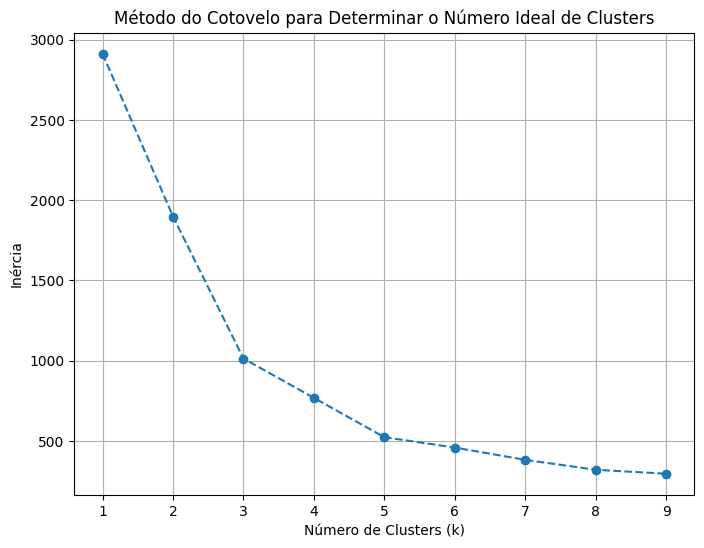

In [70]:
inertia_reduced = []
k_values_reduced = range(1, 10)  # Testando de 1 a 6 clusters

for k in k_values_reduced:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data_df[['station_avg_temp_c', 'total_cases']])
    inertia_reduced.append(kmeans.inertia_)

# Plotando o método do cotovelo com clusters reduzidos
plt.figure(figsize=(8, 6))
plt.plot(k_values_reduced, inertia_reduced, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para Determinar o Número Ideal de Clusters')
plt.grid()
plt.show()

### Testes temperatura

In [72]:
temperature_data = scaled_data_df[['station_avg_temp_c', 'total_cases']]




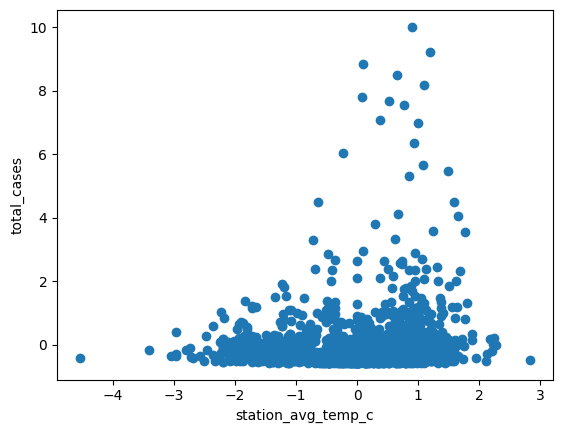

In [73]:
plt.scatter(scaled_data_df['station_avg_temp_c'].values,scaled_data_df['total_cases'])
plt.xlabel("station_avg_temp_c")
plt.ylabel("total_cases")
plt.show()

In [74]:
# Aplicando K-Means para as variáveis selecionadas (temperatura)
kmeans_temp = KMeans(n_clusters=5, random_state=42)
temperature_clusters = kmeans_temp.fit(temperature_data)

In [75]:
kmeans_temp.predict(temperature_data)

array([1, 3, 3, ..., 1, 1, 3], dtype=int32)

In [76]:
labels_clusters = kmeans.labels_

In [77]:
labels_series = pd.Series(labels_clusters, name = "label")

In [78]:
df_result = pd.concat([temperature_data, labels_series], axis = 1)

<Axes: xlabel='station_avg_temp_c', ylabel='total_cases'>

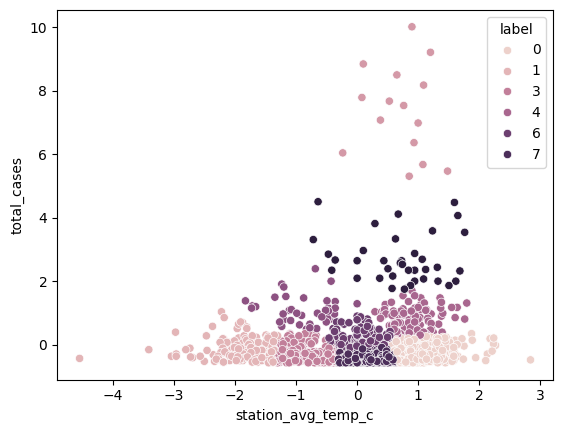

In [79]:
sns.scatterplot(data = df_result,
                x = "station_avg_temp_c",
                y = "total_cases",
                hue = "label")

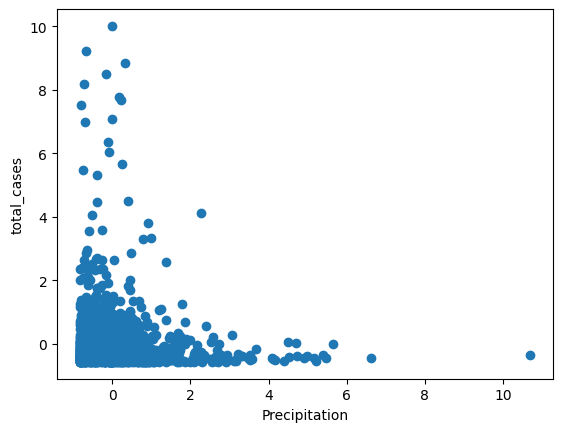

In [80]:
plt.scatter(scaled_data_df['station_precip_mm'].values,scaled_data_df['total_cases'])
plt.xlabel("Precipitation")
plt.ylabel("total_cases")
plt.show()

In [86]:
precipitation_data = scaled_data_df[['station_precip_mm', 'total_cases']]
kmeans_temp = KMeans(n_clusters=3, random_state=42)
precipitation_clusters = kmeans_temp.fit(precipitation_data)

labels_clusters = kmeans.labels_
df_result = pd.concat([precipitation_data, labels_series], axis = 1)

<Axes: xlabel='station_precip_mm', ylabel='total_cases'>

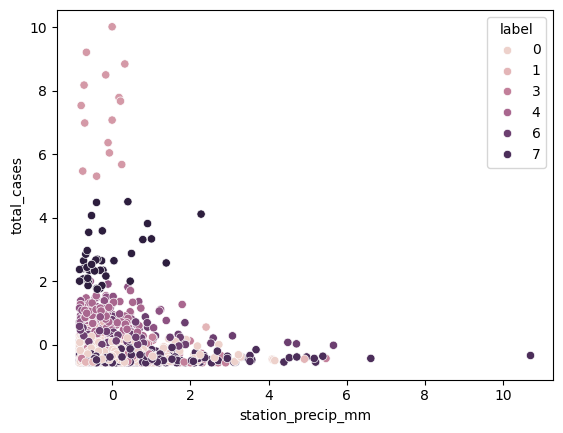

In [87]:
sns.scatterplot(data = df_result,
                x = "station_precip_mm",
                y = "total_cases",
                hue = "label")